## Linear Hough

Import Libraries

In [72]:
import numpy as np
import cv2
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt

Initializing the accumulator

In [13]:
def initialize_accumulator(image_shape, theta_resolution=180):
    w, h = image_shape[:2]  # we need the two first
    rho_max = int(np.sqrt(w ** 2 + h ** 2))
    accumulator = np.zeros((2*rho_max, theta_resolution), dtype=np.int32)
    
    return accumulator, rho_max

### Finding the edge direction

In [14]:
def edge_direction(image_gradient_x, image_gradient_y):
    direction = np.arctan2(image_gradient_y, image_gradient_x)
    direction = np.degrees(direction) % 180
    return direction

### Using the Hough Transform pseudocode provided in the slides, implement the Hough Transform algorithm.

In [53]:
def hough_transform(edges, directions, threshold, theta_resolution=180):
    w, h = edges.shape
    accumulator, rho_max = initialize_accumulator((w, h), theta_resolution)
    y_edge, x_edge = np.where(edges == 255)
    theta_value = np.linspace(0,np.pi , theta_resolution)
    for y, x in zip(y_edge, x_edge):
        for theta_ind, theta in enumerate(theta_value):
            if abs(np.cos(theta - np.deg2rad(directions[y,x]))) > threshold:
                rho = int((x * np.cos(theta) + y * np.sin(theta))) + rho_max
                accumulator[rho, theta_ind] += 1

    return accumulator

In [79]:
def find_local_maxima(accumulator, threshold):
    rho , theta = np.where(accumulator >= threshold)
    maxima = zip(rho, theta)
    return maxima

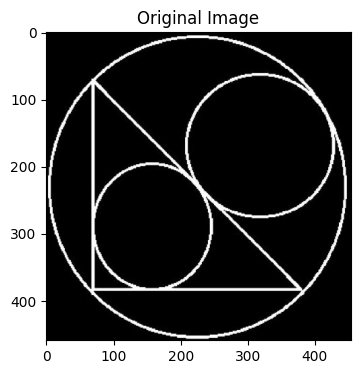

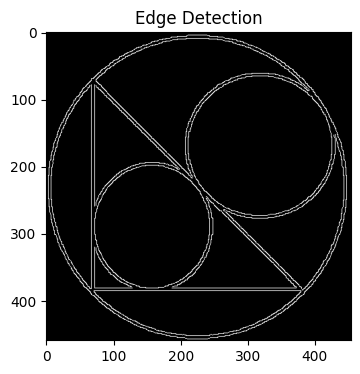

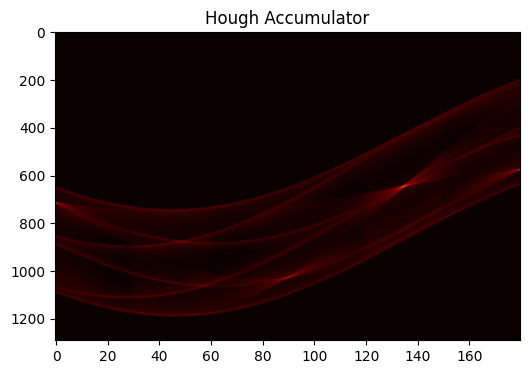

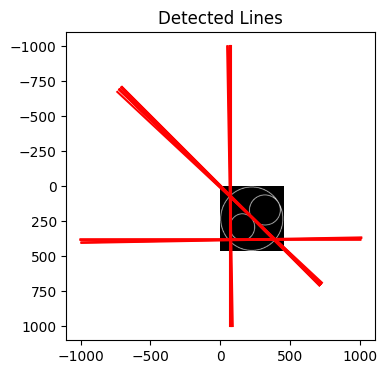

In [80]:
def process_image(image_path, edge_threshold=50, hough_threshold=120):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(6, 4))
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.show()

    edges = cv2.Canny(image, edge_threshold, edge_threshold * 2)
    plt.figure(figsize=(6, 4))
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.show()

    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    directions = edge_direction(gradient_x, gradient_y)

    accumulator = hough_transform(edges, directions, threshold=0.5)
    plt.figure(figsize=(6, 4))
    plt.imshow(accumulator, cmap='hot', aspect='auto')
    plt.title('Hough Accumulator')
    plt.show()

    maxima = find_local_maxima(accumulator, hough_threshold)
    plt.figure(figsize=(6, 4))
    plt.imshow(image, cmap='gray')
    for rho, theta in maxima:
        theta_rad = np.deg2rad(theta * (180 / accumulator.shape[1]))
        a = np.cos(theta_rad)
        b = np.sin(theta_rad)
        x0 = a * (rho - accumulator.shape[0] // 2)
        y0 = b * (rho - accumulator.shape[0] // 2)
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        plt.plot([x1, x2], [y1, y2], 'r')
    plt.title('Detected Lines')
    plt.show()


img_path = './linear_hough.JPG'
process_image(img_path)

## Circle Hough

In this section, we have an image containing several circles. We want to identify the circular shapes in the image, calculate their areas, and determine which shapes contain holes. Complete the required parts to achieve the desired output.

Import Libraries

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [146]:
def load_image(image_path):
    image = cv2.imread(image_path)

    return image

Smooth the image.

In [153]:
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.blur(image, (5, 5))

    return blur


Binarize the image

In [154]:
def apply_threshold(blur, threshold_value=128, max_value=255):
    thresh = np.where(blur >= threshold_value, max_value, 0)

    return thresh.astype(np.uint8)

Note: You can use the Library functions to apply the Hough transform.

In [207]:
def detect_circles(blur):
    circles = cv2.HoughCircles(
        blur, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
        param1=60, param2=40, minRadius=2, maxRadius=70
    )
    
    if circles is not None:
        circles = np.uint64(np.around(circles))

    return circles

In [223]:
def process_circles(image, circles, blur, thresh):
    circles = np.round(circles[0, :]).astype("int")

    for i, (x, y, r) in enumerate(circles):
        cv2.circle(image, (x, y), r, (0, 255, 0), 2)
        cv2.putText(
            image,
            str(i + 1),
            (x - r, y + 4),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (0, 0, 255),
            2
        )

        theoretical_area = math.pi * r * r

        circle_mask = np.zeros(blur.shape, dtype=np.uint8)
        cv2.circle(circle_mask, (x, y), r, 255, -1)
        circle_img = cv2.bitwise_and(thresh, circle_mask)
        actual_area = cv2.countNonZero(circle_img)

        if abs(theoretical_area - actual_area) > 220:
            print(f"Circle {i + 1} with radius {r} \033[0;31;40mhas a hole\033[0m")

        print(f"Circle {i + 1} with radius {r} has area {actual_area:.2f} (theoretical: {theoretical_area:.2f})")

    return image

In [224]:
def display_image(image, output_path='Image.JPG'):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Processed Image')
    plt.show()


Circle 1 with radius 50 has area 7841.00 (theoretical: 7853.98)
Circle 2 with radius 60 has area 11255.00 (theoretical: 11309.73)
Circle 3 with radius 61 has area 11516.00 (theoretical: 11689.87)
Circle 4 with radius 55 has area 9451.00 (theoretical: 9503.32)
Circle 5 with radius 47 has area 6921.00 (theoretical: 6939.78)
Circle 6 with radius 44 has area 6072.00 (theoretical: 6082.12)
Circle 7 with radius 50 has a hole
Circle 7 with radius 50 has area 7231.00 (theoretical: 7853.98)
Circle 8 with radius 50 has area 7827.00 (theoretical: 7853.98)
Circle 9 with radius 50 has area 7823.00 (theoretical: 7853.98)
Circle 10 with radius 47 has a hole
Circle 10 with radius 47 has area 6363.00 (theoretical: 6939.78)
Circle 11 with radius 53 has area 8747.00 (theoretical: 8824.73)
Circle 12 with radius 54 has a hole
Circle 12 with radius 54 has area 8660.00 (theoretical: 9160.88)
Circle 13 with radius 62 has area 12001.00 (theoretical: 12076.28)
Circle 14 with radius 44 has a hole
Circle 14 with 

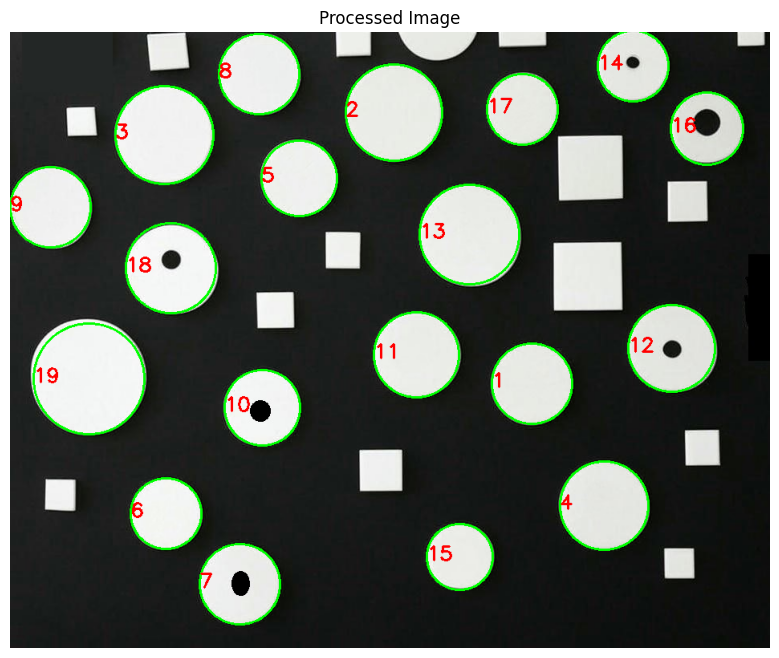

In [225]:
def main():
    image_path = "./circle_hough.jpg"
    image = load_image(image_path)
    blur = preprocess_image(image)
    thresh = apply_threshold(blur)
    circles = detect_circles(blur)
    result_image = process_circles(image, circles, blur, thresh)
    display_image(result_image)


if __name__ == "__main__":
    main()